# Visibility Merge

Divide-and-conquer algorithm for finding visibility regions.

In [1]:
import math
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mplp
import matplotlib.collections as mplc

from stuff import *

We use a numpy array of two numbers to represent a point and a 2d numpy array to represent a line segment.

The guard or point from where we will be viewing is the origin.

To represent a visibility region we use a list of 3-tuples. Each 3-tuple, called VisVector, has a unit vector representing a direction and two scalars.

In [2]:
origin = Vec2([0, 0])

VisVector = namedtuple('VisVector', 'a v r l')

So for example we can have the following segments and the visibility region from the origin would be represented with `vregion`.

In [3]:
segments = [Segment(Vec2([7, 9]), Vec2([-5, 2])),
            Segment(Vec2([-7, -7]), Vec2([0, -7])),
            Segment(Vec2([5, -5]), Vec2([10, 0]))]

vregion = []

for s in segments:
    vregion.append(VisVector(atan2(s.a), normalize(s.a), -1, norm(s.a)))
    vregion.append(VisVector(atan2(s.b), normalize(s.b), norm(s.b), -1))

To draw the segments and visiblity region we use the `draw` function.

In [4]:
def draw(segments=[], region=[], xlim=12, ylim=12, figsize=8):

    rlim = math.ceil(max(xlim, ylim) * math.sqrt(2.0))

    fig, ax = plt.subplots(figsize=(figsize, figsize))

    # Draw line segments

    lc = mplc.LineCollection(segments, linewidths=2)
    ax.add_collection(lc)

    # Draw triangles and wedges

    patches = []
    unbounded_regions = []

    iv = Vec2([1, 0])

    for i, vec in enumerate(region):

        pvec = region[i - 1] if i > 0 else VisVector(0, iv, -1, -1)

        if vec.r < 0 and vec.v != pvec.v:
            unbounded_regions.append((float(pvec.a), float(vec.a)))

        if vec.r > 0 and pvec.l > 0:
            patches.append(mplp.Polygon([origin, pvec.v * pvec.l, vec.v * vec.r], True))

    if len(region) > 0 and region[-1].v != iv:
        unbounded_regions.append((float(region[-1].a), 0))

    for (t0, t1) in unbounded_regions:
        patches.append(mplp.Wedge([0, 0], rlim, t0 * 180 / math.pi, t1 * 180 / math.pi))

    pc = mplc.PatchCollection(patches, alpha=0.4)
    ax.add_collection(pc)

    # Draw origin

    ax.plot([origin], marker='o')

    # mpl stuff

    ax.margins(0.1)
    ax.set_aspect('equal', 'box')

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)

    plt.show(block=True)

The previous segments and their visibility region would be draw like this.

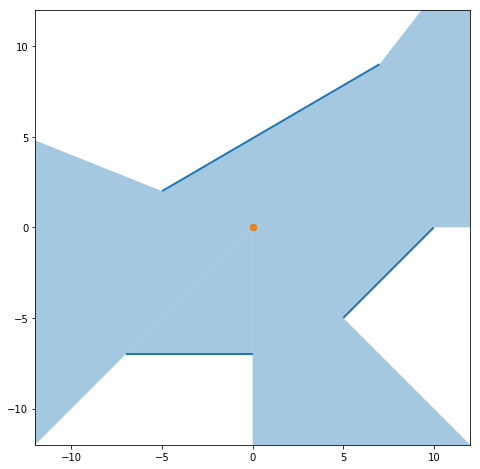

In [5]:
draw(segments, vregion)

## Algorithm

The algorithm is inspired by merge sort in which we divide the unsorted list into $n$ sublists, each containing 1 element, then we merge the them together until there is only one list, the final sorted list.

The case of visibility regions is similar, find the visiblity region for each segment and then merge them together to find the final visible region.

The visibility region for a segment would be a list of 2 VisVectors each for each point of the segment. The scalar values accompaning the vector are the lenght of how far can you see, if the value is infinite we use a negative value.

In [6]:
def visvectors_for_segment(p):
    a = p.a
    b = p.b

    if cross(a, b) < 0:
        a, b = b, a

    atan2b = atan2(b) if atan2(b) != 0 else 2 * sp.pi

    return [VisVector(atan2(a), normalize(a), -1, norm(a)), VisVector(atan2b, normalize(b), norm(b), -1)]

Now, there is an exception to this when the segment crosses the positive X axis. In that case we split the segment into two segments, like this:

In [7]:
def visible_region_for_segment(p):
    a = p.a
    b = p.b

    if cross(a, b) < 0:
        a, b = b, a

    s = b - a

    if s[1] == 0:
        return visvectors_for_segment(p)

    i = -a[1] / s[1]

    if 0 < i < 1 and a[0] + s[0] * i > 0:
        c = a + s * i

        return visvectors_for_segment(Segment(c, b)) + visvectors_for_segment(Segment(a, c))

    return visvectors_for_segment(p)

The merge function its the main merge function which hasn't been implemented yet.

There are some other functions to do first.

Ray segment intersection find the intersection of ray $v$ with segment $q$, if any.

Cut segment find cuts the segment on the ray $v$ and $w$.

In [8]:
def ray_segment_intersection(p, v):
    u = p.b - p.a

    w = p.a

    s = cross(u, v)

    if s == 0:
        return None

    r = w / s
    i = cross(v, r)

    if 0 <= i <= 1:
        return p[0] + u * i

    return None


def cut_segment(s, v, w):
    a = ray_segment_intersection(s, v)
    b = ray_segment_intersection(s, w)

    if a is None or b is None:
        return None

    return Segment(a, b)

Now we can do the merge function.

In [9]:
def merge(a, b):
    c = [a, b]
    n = [len(a), len(b)]
    i = [0, 0]

    s = []

    while i[0] < n[0] or i[1] < n[1]:

        if i[0] == n[0] or i[1] == n[1]:
            sel = 0 if i[0] < n[0] else 1
        else:
            sel = 0 if c[0][i[0]].a < c[1][i[1]].a else 1

        s.append(c[sel][i[sel]])

        if len(s) == 1:
            i[sel] = i[sel] + 1
            continue

        p = []

        for j in range(2):
            if 0 < i[j] < n[j] and c[j][i[j]].r > 0 and c[j][i[j] - 1].l > 0:
                v = c[j][i[j]]
                w = c[j][i[j] - 1]
                p.append(Segment(w.v * w.l, v.v * v.r))

        p = sorted(filter(None, [cut_segment(q, s[-2].v, s[-1].v) for q in p]), key=lambda q: tuple(map(norm, q)))

        if p:
            s[-2] = s[-2]._replace(l=norm(p[0][0]))
            s[-1] = s[-1]._replace(r=norm(p[0][1]))

        i[sel] = i[sel] + 1

    return s

And the final function the put all together is just like merge sort.

In [10]:
def mergesort(s):
    n = len(s)
    m = n // 2

    if n == 0:
        return []

    if n == 1:
        return visible_region_for_segment(s[0])

    s0 = mergesort(s[0:m])
    s1 = mergesort(s[m:n])

    return merge(s0, s1)


def visible_region(s):
    r = [p for p in s if not are_collinear(origin, *p)]
    return mergesort(r)

### Test

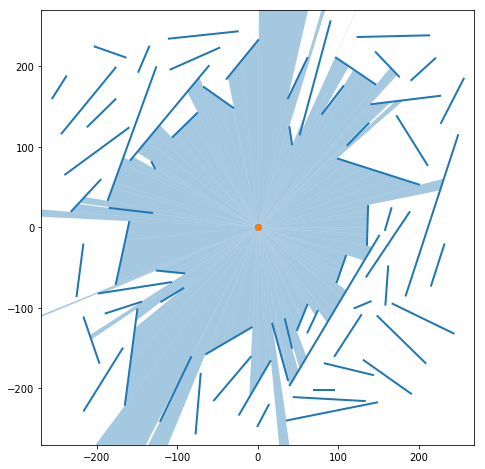

In [11]:
with open('datasets/set0.txt') as f:
    segments = parse(f.read())

xlim = 0
ylim = 0

for s in segments:
    xlim = max(xlim, abs(s[0][0]), abs(s[1][0]))
    ylim = max(ylim, abs(s[0][1]), abs(s[1][1]))

xlim = float(xlim) * 1.05
ylim = float(ylim) * 1.05

vis = visible_region(segments)

draw(segments, vis, xlim=xlim, ylim=ylim)